# Recommendation System - Collaborative Filtering

In this case, filtering is based on items rather than users and we use a Similarity Matrix of user ratings. If a user gives similar ratings to the same items that another user has also rated, then it stands to reason that the two users themselves are similar to each other, at least in terms of preferences, and would have similar preferences for other items. However, here we can reason that a set of items rated similarly by the same users are also similar to each other. We use the K-Nearest Neighbors algorithm along with Cosine Similarity to identify items that are in close proximity to each other. While the users in a dataset don’t always give explicit ratings to the items in question, we can estimate a set of implicit ratings based on certain user behaviors, such as how many times they have interacted with one item compared to another item.
[Source](https://medium.com/nerd-for-tech/building-a-reddit-recommendation-system-44ab6734d9d9)

## Collecting and Exploring the Data

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Reading the dataframe
df = pd.read_csv('reddit_user_data_count.csv')

In [ ]:
df.info()
df = df.iloc[:600000] # limit the size of the dataframe
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738737 entries, 0 to 1738736
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       object
 1   subreddit  object
 2   count      int64 
dtypes: int64(1), object(2)
memory usage: 39.8+ MB


,user,subreddit,count
0,------Username------,AskReddit,20
1,------Username------,Barca,9
2,------Username------,FIFA,4
3,------Username------,MMA,5
4,------Username------,RioGrandeValley,3


In [ ]:
# Rename columns
df.columns = ['user', 'subreddit', 'num_comments']

# Finding number of usernames and subreddits
users = df.user.unique().tolist()
subs = df.subreddit.unique().tolist()

print('Number of Usernames: {}'.format(len(users)))
print('Number of Subreddits: {}'.format(len(subs)))

Number of Usernames: 13015
Number of Subreddits: 44237


## Finding the Implicit Ratings

By calculating the total number of comments that each user has made in each subreddit, then calculating the maximum number of comments that each user has made in any subreddit, and then dividing the total by the maximum, we can generate an implicit rating that represents a user’s interest in one subreddit that they have commented on compared to all of the other subreddits that they have commented on.

rating = num of comments in subreddit / num of total comments

In [ ]:
# Finding each user's total number of comments for all subreddits
dftotal = df.groupby('user')['num_comments'].sum().reset_index(name="total_comments")

# Merging each subreddit comments and total comments onto new dataframe
dfnew = pd.merge(df, dftotal, on='user', how='left')

# Calculate a user's subreddit rating based on total and max comments
dfnew['rating'] = dfnew['num_comments']/dfnew['total_comments']*10

In [ ]:
dfnew

,user,subreddit,num_comments,total_comments,rating
0,------Username------,AskReddit,20,106,1.886792
1,------Username------,Barca,9,106,0.849057
2,------Username------,FIFA,4,106,0.377358
3,------Username------,MMA,5,106,0.471698
4,------Username------,RioGrandeValley,3,106,0.283019
...,...,...,...,...,...
599995,Neyo708,PhonesAreBad,2,396,0.050505
599996,Neyo708,Physics,3,396,0.075758
599997,Neyo708,PoliticalCompassMemes,29,396,0.732323
599998,Neyo708,PostMalone,3,396,0.075758


We need numerical values for every field to create a similarity matrix. These lines of code show how we can make a set of separate dataframes with only the dataset’s unique usernames and subreddits, assign a fixed numerical id to each based on its index number, and then add those ids back into the dataset into convenient positions.

In [ ]:
# Create new dataframe and drop duplicate users
dfusers = df.drop_duplicates(subset='user')
# Drop subs
dfusers.drop(['subreddit'], inplace=True, axis=1)
# Sort by users
dfusers = dfusers.sort_values(['user'], ascending=True)
# Reset index
dfusers.reset_index(drop=True, inplace=True)
# Create user id from index
dfusers['user_id'] = dfusers.index+1

# Create new dataframe and drop duplicate subs
dfsubs = df.drop_duplicates(subset='subreddit')
# Drop users
dfsubs.drop(['user'], inplace=True, axis=1)
# Sort by subs
dfsubs = dfsubs.sort_values(['subreddit'], ascending=True)
# Reset index
dfsubs.reset_index(drop=True, inplace=True)
# Create user id from index
dfsubs['sub_id'] = dfsubs.index+1

# Merging user id onto dataframe, moving position
dfnew = pd.merge(dfnew, dfusers, on='user', how='left')
move_pos = dfnew.pop('user_id')
dfnew.insert(1, 'user_id', move_pos)
# Merging sub id onto dataframe, moving position
dfnew = pd.merge(dfnew, dfsubs, on='subreddit', how='left')
move_pos = dfnew.pop('sub_id')
dfnew.insert(3, 'sub_id', move_pos)

/pkgs/vector_cv_project/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dfnew.drop(['num_comments_x', 'num_comments_y'], inplace=True, axis=1)
dfnew

,user,user_id,subreddit,sub_id,total_comments,rating,num_comments
0,------Username------,1,AskReddit,2146,106,1.886792,20
1,------Username------,1,Barca,2806,106,0.849057,9
2,------Username------,1,FIFA,8301,106,0.377358,4
3,------Username------,1,MMA,14433,106,0.471698,5
4,------Username------,1,RioGrandeValley,20009,106,0.283019,3
...,...,...,...,...,...,...,...
599995,Neyo708,13015,PhonesAreBad,18222,396,0.050505,1
599996,Neyo708,13015,Physics,18238,396,0.075758,1
599997,Neyo708,13015,PoliticalCompassMemes,18640,396,0.732323,25
599998,Neyo708,13015,PostMalone,18785,396,0.075758,2


## Visualizing the Data

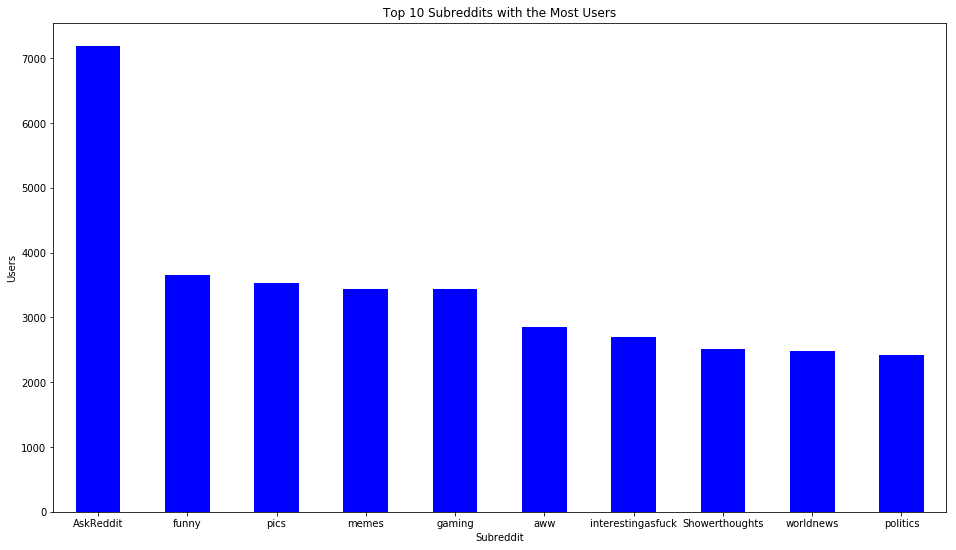

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
# Counting number of users in each subreddit
dfcounts = dfnew['subreddit'].value_counts().rename_axis('subreddit').reset_index(name='tot_users').head(10)

# Plotting the Top 10 Subreddits with the Most Users
plt.rcParams["figure.figsize"] = (16,9)
dfcounts.plot.bar(x='subreddit', y='tot_users', rot=0, legend=None, color=['blue'])
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Top 10 Subreddits with the Most Users')
plt.xlabel('Subreddit')
plt.ylabel('Users')
plt.show()

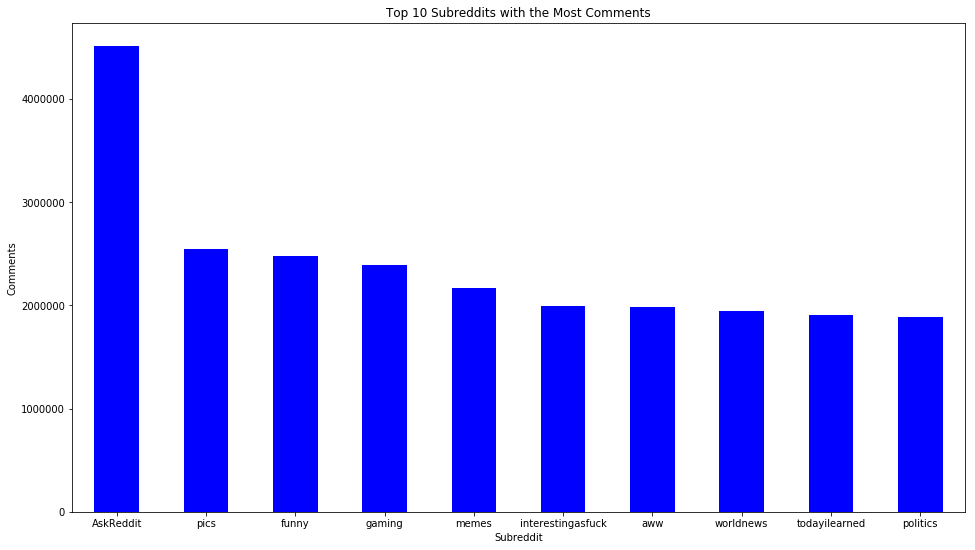

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Grouping by subreddit, summing by top 10 total comments
dfsum = dfnew.groupby(['subreddit']).sum()
dfsum = dfsum[['total_comments']].sort_values(by='total_comments', ascending=False).head(10)

# Plotting the Top 10 Subreddits with the Most Comments
plt.rcParams["figure.figsize"] = (16,9)
dfsum.plot.bar(y='total_comments', rot=0, legend=None, color=['blue'])
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Top 10 Subreddits with the Most Comments')
plt.xlabel('Subreddit')
plt.ylabel('Comments')
plt.show()

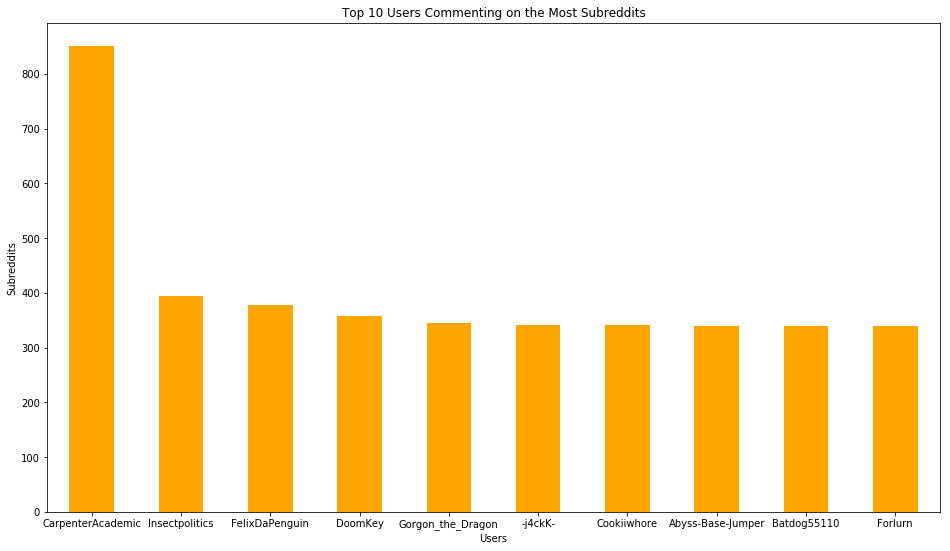

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Counting number of subreddits each user follows
dfcounts = dfnew['user'].value_counts().rename_axis('user').reset_index(name='tot_subs').head(10)

# Plotting the Top 10 Users following the most subreddits
plt.rcParams["figure.figsize"] = (16,9)
dfcounts.plot.bar(x='user', y='tot_subs', rot=0, legend=None, color=['orange'])
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Top 10 Users Commenting on the Most Subreddits')
plt.xlabel('Users')
plt.ylabel('Subreddits')
plt.show()

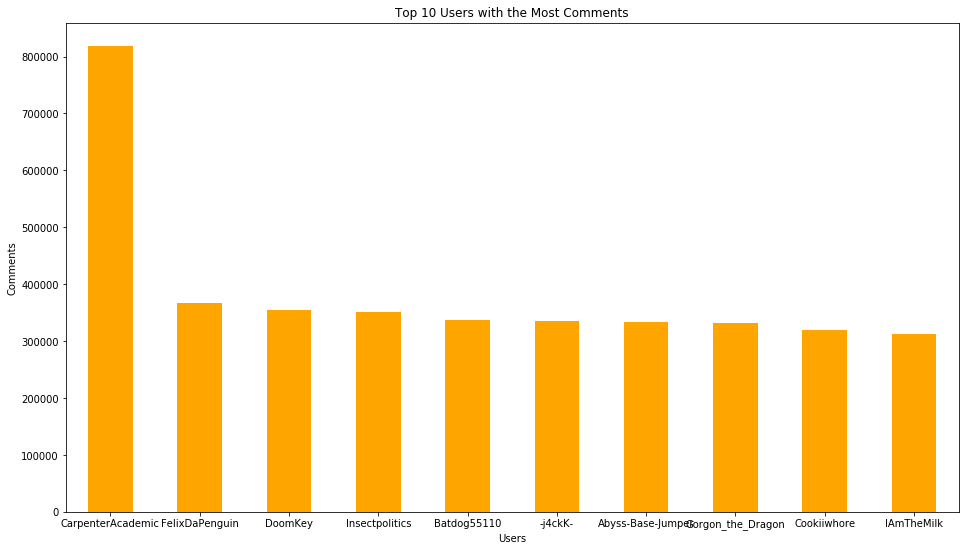

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Grouping by subreddit, summing by top 10 total comments
dfsum = dfnew.groupby(['user']).sum()
dfsum = dfsum[['total_comments']].sort_values(by='total_comments', ascending=False).head(10)

# Plotting the Top 10 Users with the Most Comments
plt.rcParams["figure.figsize"] = (16,9)
dfsum.plot.bar(y='total_comments', rot=0, legend=None, color=['orange'])
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Top 10 Users with the Most Comments')
plt.xlabel('Users')
plt.ylabel('Comments')
plt.show()

## Similarity Matrix and Data Reduction

By eliminating non-numerical values, pivoting the dataset into a grid that compares all users to all subreddits in the dataset, and replacing the values between the users and subreddits with no existing connection from null to zero, we have created a vast matrix of relationships — although it is mostly empty. This is known as the problem of sparsity, which is that most users have not commented on the majority of subreddits, and most subreddits do not have comments from the majority of users.

In [ ]:
# Create new dataframe
dfnum = dfnew

# Drop non-numerical columns
dfnew.drop(['user','subreddit','total_comments','num_comments'], inplace=True, axis=1)

In [ ]:
!pip install pandas==0.21
import pandas as pd

# Pivot dataframe into a matrix of total ratings for users and subs
dfrat = dfnum.pivot(index='sub_id', columns='user_id', values='rating')

# Replace all null values with 0
dfrat.fillna(0,inplace=True)

!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-0.21.0-cp36-cp36m-manylinux1_x86_64.whl (26.2 MB)
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.21.0 which is incompatible.
ERROR: wilds 1.0.0 has requirement pandas>=1.1.0, but you'll have pandas 0.21.0 which is incompatible.
ERROR: seaborn 0.11.1 has requirement pandas>=0.23, but you'll have pandas 0.21.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.21.0 which is incompatible.
ERROR: pandas-datareader 0.9.0 has requirement pandas>=0.23, but you'll have pandas 0.21.0 which is incompatible.
ERROR: ogb 1.2.4 has requirement pandas>=0.24.0, but you'll have pandas 0.21.0 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incom

In [ ]:
dfrat

user_id,1,2,3,4,5,6,7,8,9,10,...,13006,13007,13008,13009,13010,13011,13012,13013,13014,13015
sub_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We aggregate the number of users who commented on different subreddits, and the number of subreddits that were commented on by different users, and project those numbers onto a scatter plot to see all of the dataset represented as points.

In [ ]:
# Calculating number of users commenting per sub
num_users = dfnum.groupby('sub_id')['rating'].agg('count')

# Calculating number of subs per user
num_subs = dfnum.groupby('user_id')['rating'].agg('count')

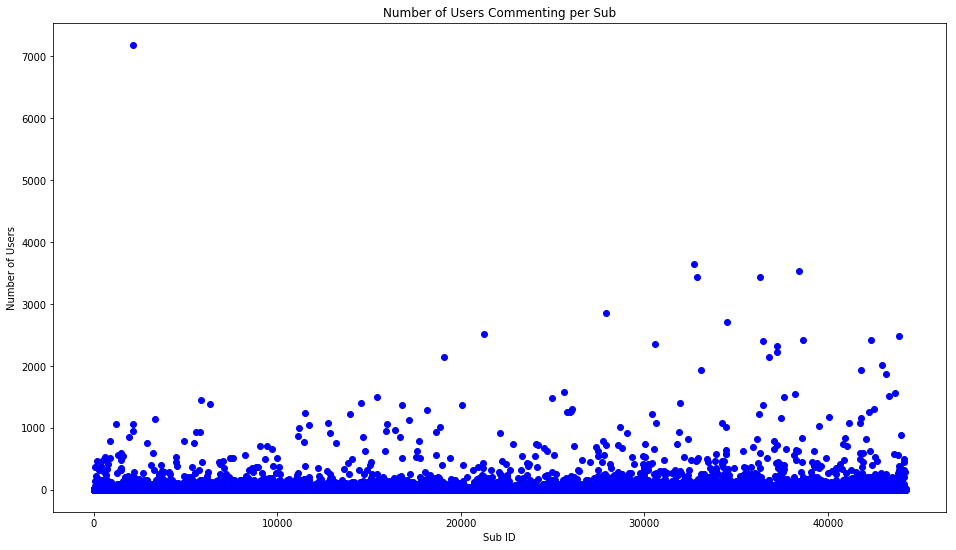

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plotting number of users commenting per sub
f,ax = plt.subplots(1,1,figsize=(16,9))
plt.scatter(num_users.index,num_users,color='blue')
plt.title('Number of Users Commenting per Sub')
plt.xlabel('Sub ID')
plt.ylabel('Number of Users')
plt.show()

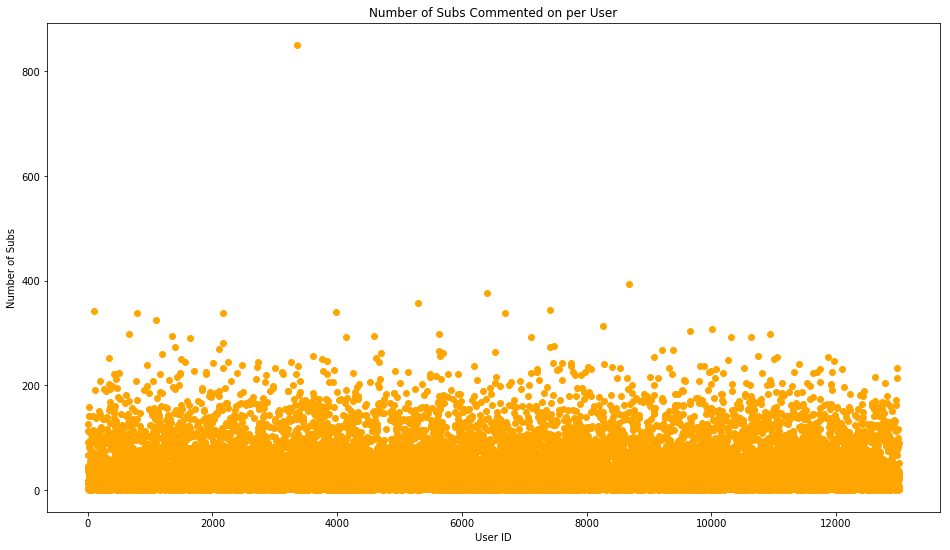

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plotting number of subs commented on per user
f,ax = plt.subplots(1,1,figsize=(16,9))
plt.scatter(num_subs.index,num_subs,color='orange')
plt.title('Number of Subs Commented on per User')
plt.xlabel('User ID')
plt.ylabel('Number of Subs')
plt.show()

We can also use a machine learning tool called the Compressed Sparse Row (CSR) to help us parse the system. Even a sparse matrix with many zeroes such as ours is rather sizable and requires a great deal of computational power, but because the zeros in the matrix contain no useful information they end up increasing the time and complexity of the matrix operations without having to. The solution to this problem is to use an alternate data structure to represent the sparse data, which ultimately amounts to ignoring the zero values and focusing only on the sections of the matrix that are more dense.

In [ ]:
# Limiting dataframe to only subreddits with 3 or more commenting users
dflast = dfrat.loc[num_users[num_users > 3].index,:]

# Limiting dataframe to only users following 1 or more subs
dflast = dflast.loc[:,num_subs[num_subs > 1].index]

# Removing sparsity from the ratings dataset
csr_data = csr_matrix(dflast.values)
dflast.reset_index(inplace=True)

In [ ]:
dflast

user_id,sub_id,1,2,3,4,5,6,7,8,9,...,13006,13007,13008,13009,13010,13011,13012,13013,13014,13015
0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14701,44218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14702,44222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14703,44225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14704,44232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Subreddit Recommender

We fit the CSR data into the KNN algorithm with the number of nearest neighbors set to 10 and the metric set to cosine distance in order to compute similarity. Then we define the function subreddit recommender, set the number of recommended subreddits to 10, instruct it to search for our inputted subreddit in the database, find similar subreddits, sort them based on similarity, and output those top 10 most similar subreddits from the list.

In [ ]:
# Using K-Nearest Neighbors as a similarity metric with cosine simlarity
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

# Defining subreddit receommender function
def subreddit_recommender(sub_name):
    num_subs_to_reccomend = 10
    sub_list = dfsubs[dfsubs['subreddit'].str.contains(sub_name)]  
    if len(sub_list):        
        sub_idx = sub_list.iloc[0]['sub_id']
        sub_idx = dflast[dflast['sub_id'] == sub_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[sub_idx],n_neighbors=num_subs_to_reccomend+1)    
        rec_sub_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1], reverse=True)[:0:-1]
        recommend_frame = []
        for val in rec_sub_indices:
            sub_idx = dflast.iloc[val[0]]['sub_id']
            idx = dfsubs[dfsubs['sub_id'] == sub_idx].index
            recommend_frame.append({'Subreddit':dfsubs.iloc[idx]['subreddit'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,num_subs_to_reccomend+1))
        return df
    else:
        return "No subreddits found. Please check your input"

### Some Examples

In [ ]:
subreddit_recommender("CryptoCurrencies")

,Subreddit,Distance
1,CryptoCurrencies,0.000000
2,CryptoCurrencyTrading,0.393424
3,hitbtc,0.422457
4,EOOD,0.541529
5,smallstreetbets,0.642423
6,altcoin,0.657056
7,CryptoMarkets,0.673704
8,binance,0.682183
9,Polkadot,0.722941
10,BinanceExchange,0.769650


In [ ]:
subreddit_recommender("ApplyingToCollege")

,Subreddit,Distance
1,ApplyingToCollege,0.000000
2,collegeresults,0.578611
3,chanceme,0.660506
4,APStudents,0.753597
5,WPI,0.789597
6,Egypt,0.794340
7,CollegeEssayReview,0.799357
8,IntltoUSA,0.800793
9,RepTronics,0.821116
10,Vanderbilt,0.821175


In [ ]:
subreddit_recommender("gaming")

,Subreddit,Distance
1,4Xgaming,0.000000
2,bitfinex,0.399472
3,EDF,0.401563
4,environmental_science,0.475836
5,CompanyOfHeroes,0.491771
6,QuantumComputing,0.510031
7,StrategyGames,0.677353
8,ASX_Bets,0.693888
9,COPYRIGHT,0.770713
10,Environmental_Careers,0.805622


In [ ]:
subreddit_recommender("ProgrammingLanguages")

,Subreddit,Distance
1,ProgrammingLanguages,0.000000
2,programmingcirclejerk,0.082522
3,shittyprogramming,0.166764
4,shittyshowerthoughts,0.474962
5,talesfromcavesupport,0.584348
6,TraditionalCurses,0.620833
7,ROGPhone3,0.639857
8,LowStakesConspiracies,0.699195
9,programminghorror,0.731219
10,banned,0.787009


As seen with the results above, this type of recommendation system, using an item matrix, works well. It can be used in future work to implement diversity.